In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression, RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

import shap
from shap import SamplingExplainer

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

from joblib import Parallel, delayed


In [3]:
# Load full feature set
label_col      = params.label_col
csv_path       = params.feat_all_csv
df_all_features = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# Filter to regular trading hours and drop bid/ask
df_reg = (
    df_all_features
      .between_time(params.sess_start, params.sess_end)
      .drop(columns=["bid", "ask"])
)

df_reg

,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_20,sma_100,atr_14,bb_lband_20,bb_hband_20,bb_width_20,plus_di_14,minus_di_14,adx_14,obv,obv_sma_14,vwap_20,vol_spike_14,vwap_dev_20,ema_7,sma_7,sma_15,sma_30,macd_diff_7_15_3,atr_15,atr_30,bb_lband_15,bb_hband_15,bb_width_15,rsi_15,stoch_k_15,stoch_d_3,plus_di_15,minus_di_15,adx_15,obv_sma_15,vwap_dev_15,vol_spike_15,r_1,r_15,r_30,vol_15,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,open,high,low,close,volume,signal,hour,day_of_week,month
2004-01-02 14:30:00,0.99032,0.40593,0.13624,0.83504,0.98892,0.90385,0.93968,0.41281,0.13571,0.83753,0.381932,0.677741,0.646377,0.355758,0.483563,0.546448,0.565886,0.546875,0.60,0.000000e+00,0.966667,0.606875,0.666667,0.357063,0.512733,0.471816,0.484536,0.000156,0.000070,0.002128,0.000122,0.000208,0.080247,0.319519,0.319233,0.000157,0.000226,0.000243,0.000191,0.000122,0.517986,0.001946,0.000000,0.000174,0.000226,0.057803,0.319235,0.006971,0.769643,0.773214,0.769286,0.772500,1056972.0,1.000000,0.251,-0.976,0.696
2004-01-02 14:31:00,0.99201,0.35982,0.09113,0.81796,0.99079,0.87288,0.90706,0.36514,0.09144,0.82166,0.156254,0.679437,0.649754,0.148455,0.483549,0.549194,0.570254,0.546875,0.60,3.384615e-08,0.973333,0.603750,0.666667,0.353726,0.512733,0.471816,0.484536,0.000156,0.000070,0.002128,0.000122,0.000208,0.080247,0.319645,0.319291,0.000172,0.000226,0.000243,0.000191,0.000139,0.517986,0.001946,0.001235,0.000174,0.000226,0.057803,0.319292,0.009264,0.769643,0.774643,0.769286,0.773571,482468.0,1.000000,0.251,-0.976,0.696
2004-01-02 14:32:00,0.99489,0.39093,0.07090,0.80903,0.99404,1.00000,0.92558,0.39461,0.07146,0.81311,0.248531,0.692256,0.664621,0.241206,0.501765,0.561108,0.583185,0.546875,0.65,8.615385e-08,0.983333,0.621875,0.666667,0.350019,0.512733,0.471816,0.487973,0.000174,0.000070,0.002128,0.000122,0.000243,0.098765,0.319901,0.319365,0.000199,0.000261,0.000261,0.000209,0.000139,0.517986,0.001946,0.001235,0.000174,0.000260,0.075145,0.319363,0.029217,0.773714,0.776786,0.772500,0.776786,980476.0,1.000000,0.251,-0.976,0.696
2004-01-02 14:33:00,0.95371,0.35552,0.06448,0.80074,0.95401,0.96324,0.94537,0.35954,0.06511,0.80512,0.056025,0.684654,0.658772,0.054969,0.471371,0.557723,0.581826,0.546875,0.65,1.923077e-08,0.846667,0.609375,0.666667,0.346681,0.514431,0.471816,0.487973,0.000174,0.000070,0.002128,0.000122,0.000260,0.104938,0.319841,0.319433,0.000210,0.000278,0.000278,0.000226,0.000139,0.517986,0.001946,0.001235,0.000174,0.000278,0.080925,0.319428,0.031138,0.776429,0.776786,0.775000,0.776429,229600.0,1.000000,0.251,-0.976,0.696
2004-01-02 14:34:00,0.80941,0.32393,0.05875,0.79304,0.81359,0.80769,0.92364,0.32828,0.05945,0.79767,0.067130,0.669032,0.644985,0.066537,0.462253,0.549749,0.576183,0.562500,0.65,0.000000e+00,0.363333,0.598125,0.666667,0.343344,0.514431,0.471816,0.487973,0.000191,0.000070,0.002128,0.000122,0.000278,0.111111,0.319765,0.319495,0.000220,0.000278,0.000295,0.000226,0.000157,0.517986,0.001946,0.001235,0.000174,0.000295,0.092486,0.319487,0.037830,0.776429,0.776786,0.775000,0.775000,292208.0,1.000000,0.251,-0.976,0.696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.67217,0.36312,0.07485,0.30194,0.66709,0.73661,0.62549,0.35895,0.07958,0.28287,0.117495,0.652911,0.635234,0.113816,0.478595,0.527683,0.541606,0.515625,0.60,1.730769e-05,0.000000,0.518125,0.666667,0.327030,0.808149,0.749478,0.625430,3.399805,3.398280,0.534043,3.397055,3.399910,0.024691,0.321726,0.321693,3.402269,3.403066,3.402026,3.399395,3.398880,0.661871,0.480545,0.270370,3.393991,3.401916,0.023121,0.321703,0.024910,196.680000,196.860000,196.630000,196.815000,385695.0,0.684908,-0.976,0.039,-0.861
2025-06-18 20:57:00,0.61669,0.34721,0.06704,0.32868,0.61512,0.58962,0.65041,0.34426,0.07170,0.30770,0.126236,0.647611,0.629672,0.123111,0.469708

In [4]:
# Separate feature matrix X and target vector y
all_features = [c for c in df_reg.columns if c != label_col]
X_all        = df_reg[all_features]
y            = df_reg[label_col]

# Remove low-variance features
std_threshold    = 0.01
feature_stds     = X_all.std()
low_var_feats    = feature_stds[feature_stds < std_threshold].index.tolist()
kept_var_feats   = feature_stds[feature_stds >= std_threshold].index.tolist()

print("Dropped low-variance features:", low_var_feats)

Dropped low-variance features: ['obv_sma_14', 'sma_7', 'macd_diff_7_15_3', 'atr_15']


In [31]:
X_var = X_all[kept_var_feats]

# Compute full correlation matrix
corr_full = X_var.corr()

# Prune highly-correlated features (|ρ| > 0.9)
upper_tri = corr_full.abs().where(
    np.triu(np.ones(corr_full.shape), k=1).astype(bool)
)

to_drop = set()
for feat in upper_tri.columns:
    # find features correlated above threshold
    high_corr = upper_tri.index[upper_tri[feat] > 0.9].tolist()
    if high_corr:
        group     = [feat] + high_corr
        # pick the one in group most correlated with the target
        best_feat = X_var[group].corrwith(y).abs().idxmax()
        to_drop.update(set(group) - {best_feat})

pruned_feats = [f for f in kept_var_feats if f not in to_drop]
print('Dropped features:', to_drop)

X = X_var[pruned_feats]
corr_pruned  = X.corr()
corr_pruned

Dropped features: {'close', 'bb_lband_15', 'eng_bb', 'eng_ma', 'sma_20', 'bb_width_20', 'low', 'open', 'eng_adx', 'bb_hband_20', 'atr_14', 'eng_macd', 'plus_di_15', 'eng_rsi', 'r_30', 'r_1', 'rsi_15', 'high', 'obv_sma_15', 'plus_di_14', 'vol_spike_15', 'minus_di_14', 'bb_width_15', 'bb_lband_20', 'vwap_dev_15', 'r_15', 'eng_obv'}


,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_100,adx_14,obv,vwap_20,vol_spike_14,vwap_dev_20,ema_7,sma_15,sma_30,atr_30,bb_hband_15,stoch_k_15,stoch_d_3,minus_di_15,adx_15,vol_15,eng_atr_div,volume,hour,day_of_week,month
rsi_14,1.000000,0.766847,-0.794086,-0.000194,0.832574,0.705392,-0.003564,0.717794,0.678043,0.588478,0.283148,0.012603,0.549570,0.457177,0.344898,-0.007925,0.011069,-0.015846,0.173451,0.222611,-0.035897,-0.010659,0.012924,0.016224,-0.003921
macd_line_12_26_9,0.766847,1.000000,-0.612449,0.073489,0.576579,0.531625,0.074605,0.576276,0.540888,0.487984,0.236354,0.060524,0.624481,0.366628,0.280719,0.000950,-0.009267,0.072942,0.109364,0.162418,0.032047,0.033886,0.022624,0.027333,-0.008078
macd_signal_12_26_9,-0.794086,-0.612449,1.000000,0.037339,-0.603305,-0.541886,0.090683,-0.589568,-0.557944,-0.497358,-0.237860,0.049876,-0.633372,-0.368692,-0.283458,0.026644,0.014842,0.070819,-0.111552,-0.165119,0.065073,0.027209,0.005698,-0.011236,-0.006822
macd_diff_12_26_9,-0.000194,0.073489,0.037339,1.000000,-0.012186,0.002436,0.015935,-0.005239,-0.004458,-0.005561,0.000775,0.380052,0.018007,-0.020899,-0.000997,0.074717,0.001707,0.305285,0.024299,0.006154,0.142228,0.131283,0.042481,0.022897,-0.012025
sma_100,0.832574,0.576579,-0.603305,-0.012186,1.000000,0.743571,0.003928,0.637976,0.445849,0.519569,0.284344,0.008851,0.300893,0.303076,0.398982,-0.001578,0.014334,-0.005250,0.074538,0.306694,-0.017158,-0.006296,0.005614,0.009295,-0.002469
adx_14,0.705392,0.531625,-0.541886,0.002436,0.743571,1.000000,-0.003309,0.815453,0.560775,0.719366,0.620358,-0.000054,0.310285,0.328557,0.480174,0.002260,0.002025,0.017664,0.070375,0.385103,0.013615,-0.008771,0.010697,0.007363,-0.001844
obv,-0.003564,0.074605,0.090683,0.015935,0.003928,-0.003309,1.000000,-0.007994,-0.006747,-0.009476,-0.005738,0.142377,-0.010278,-0.003818,0.003290,0.006765,0.004350,-0.010798,-0.006641,0.016180,0.009435,0.381929,0.041939,0.000822,0.000144
vwap_20,0.717794,0.576276,-0.589568,-0.005239,0.637976,0.815453,-0.007994,1.000000,0.705704,0.815833,0.552895,0.004437,0.405775,0.451442,0.422727,0.001635,0.005204,-0.007613,0.094052,0.159127,-0.026371,-0.024182,0.011952,0.008556,-0.001535
vol_spike_14,0.678043,0.540888,-0.557944,-0.004458,0.445849,0.560775,-0.006747,0.705704,1.000000,0.581015,0.223561,0.009804,0.438834,0.527822,0.164507,-0.001403,0.008146,-0.031517,0.132618,0.029816,-0.054185,-0.026910,0.013863,0.012355,-0.002324
vwap_dev_20,0.588478,0.487984,-0.497358,-0.005561,0.519569,0.719366,-0.009476,0.815833,0.581015,1.000000,0.569034,0.007753,0.352773,0.399924,0.428916,0.001288,0.003739,-0.006206,0.077187,0.088906,-0.016872,-0.019779,0.010485,0.006869,-0.000968


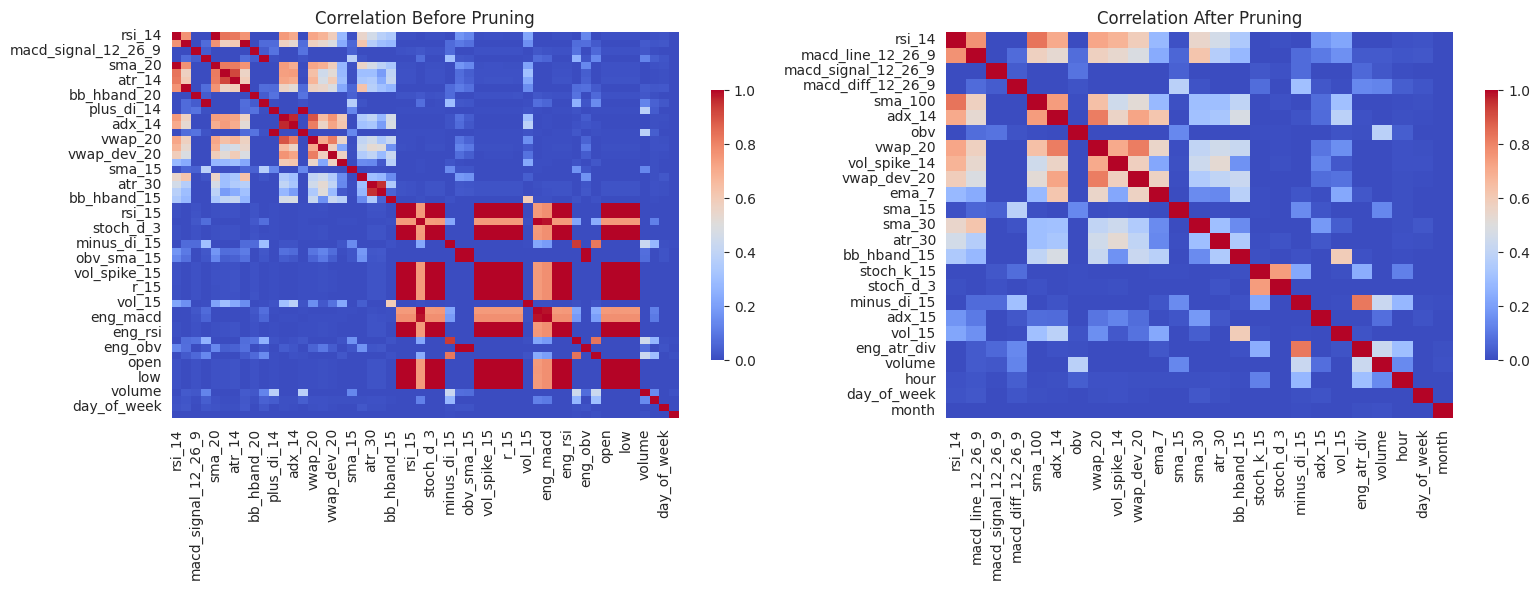

In [32]:
# Plot before vs. after heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    corr_full, ax=axes[0],
    vmin=0, vmax=1, cmap="coolwarm", cbar_kws={"shrink": .7}
)
axes[0].set_title("Correlation Before Pruning")

sns.heatmap(
    corr_pruned, ax=axes[1],
    vmin=0, vmax=1, cmap="coolwarm", cbar_kws={"shrink": .7}
)
axes[1].set_title("Correlation After Pruning")

plt.tight_layout()
plt.show()

In [33]:
# Prepare master dict for feature importances
features_importances = {feat: {} for feat in pruned_feats}
features_cols = pruned_feats

df_feat_filt = df_reg[features_cols + [label_col]]
df_feat_filt

,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_100,adx_14,obv,vwap_20,vol_spike_14,vwap_dev_20,ema_7,sma_15,sma_30,atr_30,bb_hband_15,stoch_k_15,stoch_d_3,minus_di_15,adx_15,vol_15,eng_atr_div,volume,hour,day_of_week,month,signal
2004-01-02 14:30:00,0.99032,0.40593,0.13624,0.83504,0.90385,0.646377,0.355758,0.546448,0.565886,0.546875,0.60,0.966667,0.606875,0.512733,0.484536,0.002128,0.000122,0.080247,0.319519,0.517986,0.006971,1056972.0,0.251,-0.976,0.696,1.000000
2004-01-02 14:31:00,0.99201,0.35982,0.09113,0.81796,0.87288,0.649754,0.148455,0.549194,0.570254,0.546875,0.60,0.973333,0.603750,0.512733,0.484536,0.002128,0.000122,0.080247,0.319645,0.517986,0.009264,482468.0,0.251,-0.976,0.696,1.000000
2004-01-02 14:32:00,0.99489,0.39093,0.07090,0.80903,1.00000,0.664621,0.241206,0.561108,0.583185,0.546875,0.65,0.983333,0.621875,0.512733,0.487973,0.002128,0.000122,0.098765,0.319901,0.517986,0.029217,980476.0,0.251,-0.976,0.696,1.000000
2004-01-02 14:33:00,0.95371,0.35552,0.06448,0.80074,0.96324,0.658772,0.054969,0.557723,0.581826,0.546875,0.65,0.846667,0.609375,0.514431,0.487973,0.002128,0.000122,0.104938,0.319841,0.517986,0.031138,229600.0,0.251,-0.976,0.696,1.000000
2004-01-02 14:34:00,0.80941,0.32393,0.05875,0.79304,0.80769,0.644985,0.066537,0.549749,0.576183,0.562500,0.65,0.363333,0.598125,0.514431,0.487973,0.002128,0.000122,0.111111,0.319765,0.517986,0.037830,292208.0,0.251,-0.976,0.696,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.67217,0.36312,0.07485,0.30194,0.73661,0.635234,0.113816,0.527683,0.541606,0.515625,0.60,0.000000,0.518125,0.808149,0.625430,0.534043,3.397055,0.024691,0.321726,0.661871,0.024910,385695.0,-0.976,0.039,-0.861,0.684908
2025-06-18 20:57:00,0.61669,0.34721,0.06704,0.32868,0.58962,0.629672,0.123111,0.525829,0.542649,0.515625,0.60,0.000000,0.522500,0.813243,0.608247,0.553191,3.397020,0.024691,0.321606,0.568345,0.025902,460630.0,-0.976,0.039,-0.861,0.612206
2025-06-18 20:58:00,0.61473,0.33627,0.06493,0.35352,0.58091,0.628744,0.125853,0.523206,0.545497,0.515625,0.60,0.000000,0.526250,0.814941,0.584192,0.529787,3.397020,0.030864,0.321469,0.510791,0.025499,525245.0,-0.976,0.039,-0.861,0.610468
2025-06-18 20:59:00,0.47540,0.29058,0.16002,0.34896,0.17135,0.616953,0.337903,0.514750,0.538547,0.515625,0.60,0.000000,0.511875,0.753820,0.467354,0.570213,3.396968,0.030864,0.320926,0.287770,0.031509,2075503.0,-0.976,0.039,-0.861,0.477090


In [34]:
# Utility: update the dict
def update_feature_importances(fi_dict, importance_type, values: pd.Series):
    """
    fi_dict: master dict
    importance_type: one of "corr","mi","perm","shap","lasso"
    values: pd.Series indexed by feature name
    """
    for feat, val in values.items():
        if feat in fi_dict:
            fi_dict[feat][importance_type] = val


In [35]:
def live_feature_importance(
    df: pd.DataFrame,
    features: list[str],
    label: str,
    method: str,               # "corr", "mi", "perm", "shap", "lasso"
    compute_fn,                # function(feature_name) → importance_value
    threshold: float = None
):
    """
    Generic live plotter for a sequence of feature importances.
    
    - df        : full dataframe
    - features  : list of column names to score
    - label     : target column name (for context in title)
    - method    : text legend ("Corr", "Mutual Info", etc.)
    - compute_fn: a callable f → score[f]
    - threshold : optional vertical line in the bar chart
    """
    # accumulator
    scores = {}

    # loop with progress bar
    for f in tqdm(features, desc=f"{method}"):
        # compute
        val = compute_fn(f)
        scores[f] = val

        # update on‐screen plot
        clear_output(wait=True)
        series = pd.Series(scores).sort_values()
        plt.figure(figsize=(6, max(3, len(series)*0.25)))
        sns.barplot(x=series.values, y=series.index, palette="vlag")
        if threshold is not None:
            plt.axvline(threshold, color="gray", linestyle="--")
            if method=="Corr":
                plt.axvline(-threshold, color="gray", linestyle="--")
        plt.title(f"{method} Importance (partial) for {label}")
        plt.xlabel("Importance")
        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        # tiny pause so the UI can breathe (optional)
        time.sleep(0.02)

    # final return
    return pd.Series(scores).sort_values()

/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


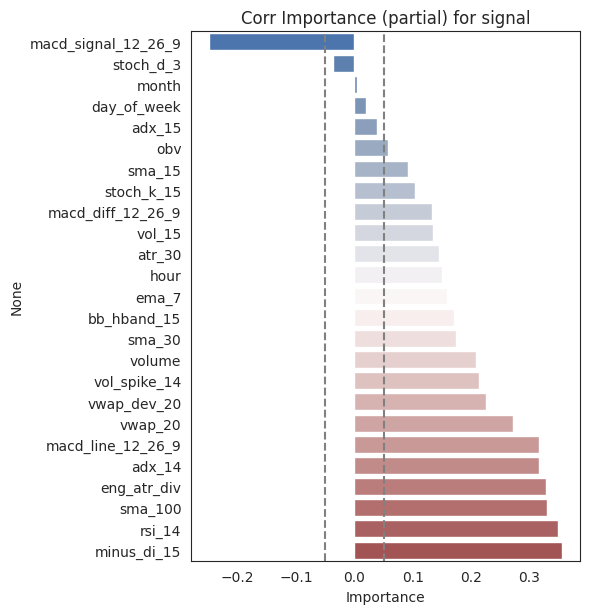

In [36]:
'''
# 1) Correlation live

This method uses Pearson’s correlation coefficient to quantify the linear relationship
between each input feature and the target variable.  A coefficient ρ close to ±1
indicates a strong linear association (positive or negative), whereas a value near 0
suggests little to no linear dependency.

How this function works:
  • For every feature f in your dataset, compute ρ = corr(f, y), the correlation with y.  
  • The helper live_feature_importance streams an updating bar chart as you loop
    through features, hiding any whose |ρ| falls below a threshold (here 0.05).  
  • At the end, you get a pd.Series of all ρ values, sorted by magnitude.  
  • Finally, update_feature_importances stores that series under the key "corr"
    in your master dictionary, so you can compare correlation importance alongside
    other measures.
'''


def corr_fn(feat):
    return df_feat_filt[feat].corr(df_feat_filt[label_col])

corr_scores = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="Corr",
    compute_fn=corr_fn,
    threshold=0.05
)

update_feature_importances(features_importances, "corr", corr_scores)


/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


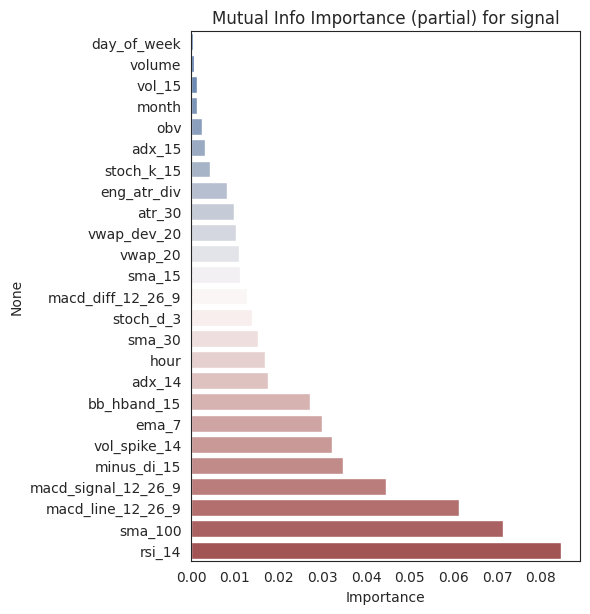

In [37]:
"""
2) Mutual Information (MI) 

measures any statistical dependency—linear or non-linear—
between a feature and the target. It quantifies how much knowing the feature
reduces uncertainty about the target; higher MI indicates a stronger dependency.

How this implementation works:
  • Pre-extract X_full (all features) and y_full (target) as NumPy arrays once,
    eliminating repeated pandas indexing in the loop.
  • Define mutual_info_hist(x, y, bins=20, eps=1e-9):
      – Builds a 2D histogram of x vs. y (bins² cells)
      – Converts counts to joint/marginal probabilities
      – Computes I(X;Y) ≈ Σ p(x,y)·log[p(x,y)/(p(x)p(y))] in pure NumPy
      – Runs in O(n + bins²), sub-millisecond for typical data sizes
  • Build a dict mapping feature names → column indices for O(1) lookup.
  • compute_fn(feat) uses that dict to slice X_full[:, idx] and calls mutual_info_hist.
  • Pass compute_fn (unchanged signature) to live_feature_importance:
      – Streams a bar chart update per feature
      – Threshold zero ensures all features appear
  • Finally, update the master importance dict under "mi" with the computed scores.
"""


# 0) Ensure we have a simple list of feature names and a lookup dict
feature_list = list(features_cols)  
col_pos = {feat: i for i, feat in enumerate(feature_list)}

# 1) Pre-extract your full feature matrix and target vector
X_full = df_feat_filt[feature_list].fillna(0).to_numpy()
y_full = df_feat_filt[label_col].to_numpy()

# 2) Fast histogram-based MI estimator (as before)
def mutual_info_hist(x: np.ndarray, y: np.ndarray, bins: int = 20, eps: float = 1e-9) -> float:
    x = np.nan_to_num(x)
    y = np.nan_to_num(y)
    counts, _, _ = np.histogram2d(x, y, bins=bins)
    counts += eps
    p_xy = counts / counts.sum()
    p_x  = p_xy.sum(axis=1, keepdims=True)
    p_y  = p_xy.sum(axis=0, keepdims=True)
    mi_matrix = p_xy * np.log(p_xy / (p_x @ p_y))
    return float(mi_matrix.sum())

# 3) New compute_fn that uses our lookup dict
def mi_fn(feat: str) -> float:
    idx = col_pos[feat]        # O(1) lookup instead of .index()
    return mutual_info_hist(X_full[:, idx], y_full, bins=20)

# 4) Call your live plotter unchanged
mi_scores = live_feature_importance(
    df=df_feat_filt,
    features=feature_list,
    label=label_col,
    method="Mutual Info",
    compute_fn=mi_fn,
    threshold=0.0
)

# 5) Store results
update_feature_importances(features_importances, "mi", mi_scores)



/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


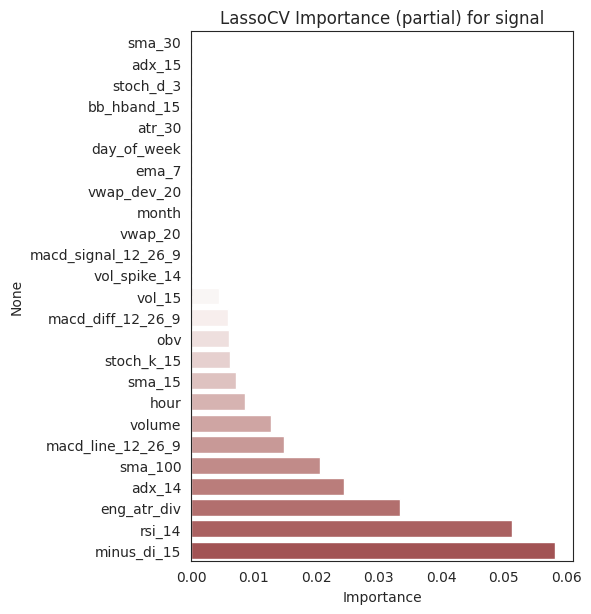

In [38]:
"""
3) LassoCV (coordinate descent)

Lasso regression adds an ℓ₁ penalty to OLS, zeroing many coefficients
and performing embedded feature selection. We stream the final
absolute weights as “importances” in real time—but do all the heavy
lifting exactly once up front.

How this optimized version works:
  1) Standardize X and center y one time only, outside the loop.
  2) Fit LassoCV on the full feature matrix:
       • Use TimeSeriesSplit for time‐aware CV.
       • Supply n_jobs=-1 to parallelize across cores.
       • Densify or coarsen the α grid as needed.
  3) Extract |coefficients| into a dict for O(1) lookup.
  4) Define compute_fn(feat) = dict_lookup(feat) (no pandas indexing).
  5) Call live_feature_importance unchanged: it now updates
     instantly because compute_fn is just a dict lookup.
  6) Finally, record the sorted Series under "lasso" in your importances.
"""

# 1) Fit scaler & center once
scaler = StandardScaler()
Xz = scaler.fit_transform(X)         # fit on X once
yz = y - y.mean()                    # center target

# 2) Fit LassoCV once with parallel, time‐aware CV
lasso_cv = LassoCV(
    alphas = np.logspace(-4, -1, 30),         # adjust grid density
    cv     = TimeSeriesSplit(n_splits=5),     # time-series folds
    max_iter = 10000,
    n_jobs    = -1,                            # parallelize
    random_state = 0
).fit(Xz, yz)

# 3) Build a Series of absolute coefficients, sorted
lasso_scores = pd.Series(
    np.abs(lasso_cv.coef_),
    index=features_cols
).sort_values()

# 4) Dict lookup for O(1) compute_fn
coef_dict = lasso_scores.to_dict()
def lasso_fn(feat: str) -> float:
    return coef_dict[feat]

# 5) Stream‐plot via live_feature_importance 
_ = live_feature_importance(
    df       = df_feat_filt,
    features = features_cols,
    label    = label_col,
    method   = "LassoCV",
    compute_fn = lasso_fn,
    threshold  = 0.0
)

# 6) Store into your master importances
update_feature_importances(features_importances, "lasso", lasso_scores)


In [39]:
# ────────────────────────────────────────────────────────────────────
# Incremental RF fit with warm_start
# ────────────────────────────────────────────────────────────────────

'''
Initialize a warm‐start RandomForest,
grow it one tree at a time up to TARGET_TREES,
so we can reuse the same fitted model for RFE, permutation importance, and SHAP.
'''

rf = RandomForestRegressor(
    warm_start=True,
    n_estimators=20, # Using a larger forest (n_estimators) to stabilize .feature_importances_ (slower)
    max_depth=5,
    n_jobs=-1,
    random_state=0
)

TARGET_TREES = 10
for i in tqdm(range(TARGET_TREES), desc="Training RF trees"):
    rf.set_params(n_estimators=i + 1)
    rf.fit(X, y)


Training RF trees:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


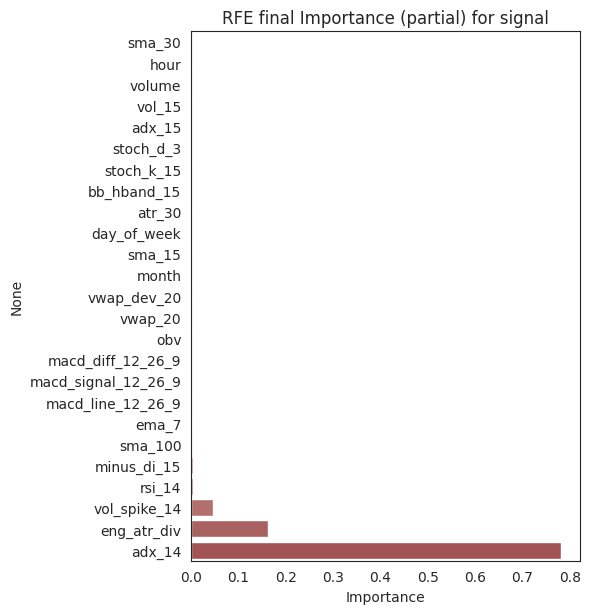

In [40]:
'''
# 4) RFE live (recursive feature elimination with CV)

Recursive Feature Elimination (RFE) is a wrapper approach that repeatedly fits
a model, ranks features by importance, drops the weakest feature, and refits
until only the desired number remain.  This process exposes interactions and
collinearity effects as the feature set shrinks.

How this function works:
  • Start with your full feature list and clone a fresh RF each iteration.  
  • Fit the RF on the current subset, extract raw .feature_importances_.  
  • Use live_feature_importance to stream‐plot importance bars—dropped features
    show zero importance once eliminated.  
  • Drop the single least‐important feature and repeat until you keep
    n_features_to_keep survivors.  
  • Fit one final RF on those survivors, stream the final plot, and then
    call update_feature_importances exactly once, saving that last importance
    Series under "rfe".
'''

remaining = features_cols.copy()
# how many features you want at the end
n_features_to_keep = len(remaining)  # this way it runs only once to save time (but a lower number should be set here)

rounds = len(remaining) - n_features_to_keep

from sklearn.model_selection import KFold

for i in range(rounds):
    # cross-validate RF on current subset to get stable importances
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    imps_list = []
    for train_idx, val_idx in kf.split(df_feat_filt):
        model_cv = clone(rf)
        model_cv.warm_start = False
        model_cv.fit(df_feat_filt.iloc[train_idx][remaining], df_feat_filt.iloc[train_idx][label_col])
        imps_list.append(pd.Series(
            model_cv.feature_importances_,
            index=remaining
        ))

    # average importances across folds
    imps = pd.concat(imps_list, axis=1).mean(axis=1)

    # compute_fn returns 0.0 for dropped features
    def compute_fn(feat, imps=imps):
        return float(imps.get(feat, 0.0))

    # live‐plot
    _ = live_feature_importance(
        df=df_feat_filt,
        features=features_cols,             # full list for consistent axis
        label=label_col,                    
        method=f"RFE round {i+1}",
        compute_fn=compute_fn,
        threshold=0.0
    )
    plt.show()                              # force display

    # drop the least‐important feature
    worst = imps.idxmin()
    remaining.remove(worst)

# final fit on survivors
final = clone(rf)
final.warm_start = False
final.fit(df_feat_filt[remaining], df_feat_filt[label_col])

final_imps = pd.Series(final.feature_importances_, index=remaining)

# final live‐plot
_ = live_feature_importance(
    df=df_feat_filt,
    features=features_cols,
    label=label_col,
    method="RFE final",
    compute_fn=lambda feat: float(final_imps.get(feat, 0.0)),
    threshold=0.0
)
plt.show()

# save only the final importances
update_feature_importances(
    fi_dict=features_importances,
    importance_type="rfe",
    values=final_imps
)


/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


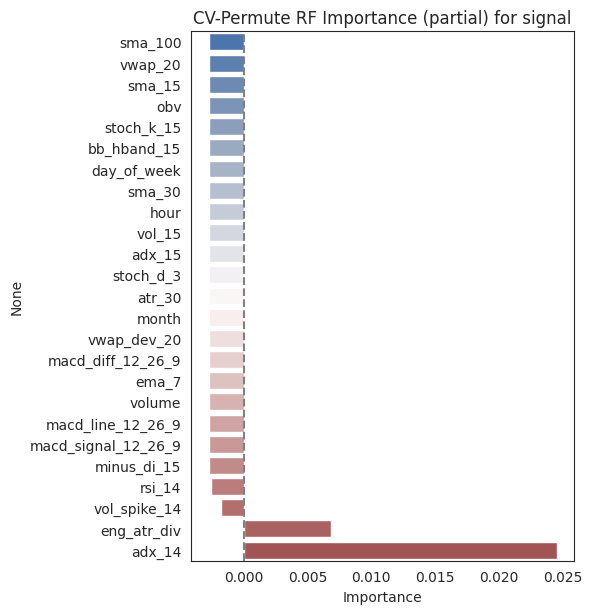

In [41]:
"""
5) Permutation Importance (CV-based)

Permutation importance quantifies how much shuffling a feature in held-out
data degrades model performance (e.g. ↑MSE).  We gather both:

 A) Impurity importances from the in-memory forest (rf.feature_importances_).
 B) CV-based permutation importances, averaged across folds.

This optimized implementation:

  • Disables warm_start on the RF so each fit is fresh (no ‘warm-start’ warnings).  
  • Uses joblib’s Parallel + delayed to dispatch each fold’s:
      – fresh RF clone, fit on train
      – permutation_importance on test (n_repeats reduced, n_jobs=1)
    in parallel across CPU cores.
  • Averages the per-fold importance vectors into one Series.
  • Finally calls live_feature_importance unchanged to stream the bar chart.
"""

# ─── A) Impurity importances ────────────────────────────────────

impurity_imp = pd.Series(rf.feature_importances_, index=features_cols)
update_feature_importances(features_importances, "perm_imp", impurity_imp)

# ─── B) Pre-fit folds with subsampled test sets ───────────────────────────────

kf = KFold(n_splits=4, shuffle=True, random_state=0)

# tuning knobs
MAX_TEST_ROWS = 400    # subsample per fold
rng = np.random.RandomState(0)

fold_models   = []
fold_X_tests  = []
fold_y_tests  = []
fold_base_mse = []

for tr_idx, te_idx in kf.split(X):
    # 1) fresh clone of your RF, no warm_start warnings
    model = clone(rf).set_params(warm_start=False)
    model.fit(X.iloc[tr_idx], y.iloc[tr_idx])

    # 2) full test slice to get a baseline MSE
    X_full_te = X.iloc[te_idx]
    y_full_te = y.iloc[te_idx]
    base_pred = model.predict(X_full_te)            # DataFrame → no warning
    mse0      = mean_squared_error(y_full_te, base_pred)

    # 3) subsample that test slice for permutation speed
    if len(te_idx) > MAX_TEST_ROWS:
        # te_idx is a list of positional indices, so use iloc, not loc
        samp_pos = rng.choice(te_idx, size=MAX_TEST_ROWS, replace=False)
        X_te = X.iloc[samp_pos]    # DataFrame by position
        y_te = y.iloc[samp_pos]
    else:
        X_te = X_full_te.copy()
        y_te = y_full_te.copy()

    fold_models.append(model)
    fold_X_tests.append(X_te)
    fold_y_tests.append(y_te)
    fold_base_mse.append(mse0)

# build a fast lookup for feature → column index
feature_list = list(features_cols)
col_idx      = {f:i for i,f in enumerate(feature_list)}

# ─── C) super-fast one-feature-at-a-time permutation fn ──────────────────────

def perm_fn(feat: str) -> float:
    """
    Shuffle only `feat` in each fold’s subsampled test set,
    predict, compute ΔMSE vs baseline, and return the average.
    """
    idx    = feat  # since X_te is a DataFrame, we can use column names directly
    deltas = []

    for model, X_te, y_te, mse0 in zip(
        fold_models, fold_X_tests, fold_y_tests, fold_base_mse
    ):
        Xp = X_te.copy()
        # in-place shuffle that single column
        Xp[idx] = rng.permutation(Xp[idx].values)

        mse1 = mean_squared_error(y_te, model.predict(Xp))
        deltas.append(mse1 - mse0)

    return float(np.mean(deltas))

# ─── D) live plotting ───────────────────────────────────

perm_scores_live = live_feature_importance(
    df         = df_feat_filt,
    features   = feature_list,
    label      = label_col,
    method     = "CV-Permute RF",
    compute_fn = perm_fn,
    threshold  = 0.0
)

# ─── E) finally store the end-of-loop Series ─────────────────────────────────

update_feature_importances(
    features_importances,
    "perm_CV",
    perm_scores_live
)


/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


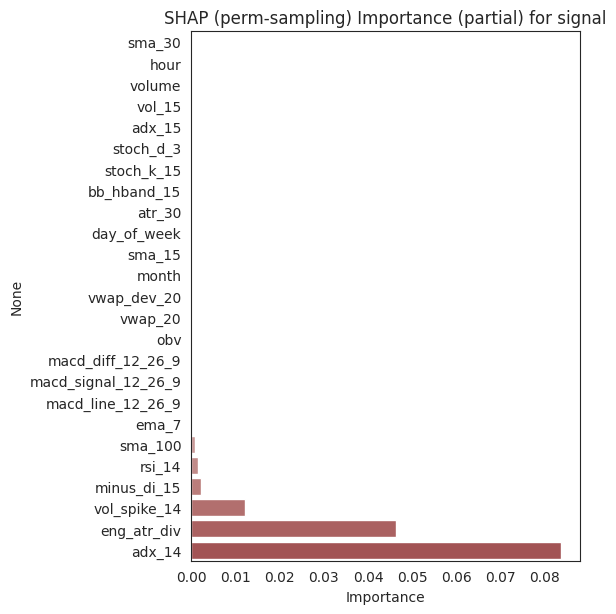

In [42]:
'''
# 6) SHAP live (sampling‐style via PermutationExplainer)

SHAP (SHapley Additive exPlanations) uses game‐theoretic Shapley values to
attribute each model prediction to individual feature contributions. The
mean absolute SHAP value per feature approximates its global importance.

How this function works:
  • Randomly sample a subset of rows (e.g., 2,000) as a reference for
    “missing” value permutations.  
  • Instantiate a high‐level shap.Explainer with algorithm="permutation",
    wrapping rf.predict and the reference sample.  
  • Compute SHAP values on the sample, limiting total model calls per instance
    (max_evals=100) for a speed–variance trade‐off.  
  • Take the mean of absolute SHAP values across all instances for each feature.  
  • Stream these mean |SHAP| values with live_feature_importance.  
  • Store the final Series under "shap" for comparison with other methods.
'''

# 1) build a small reference set for “missing” value draws
X_sample = shap.sample(X, 2000, random_state=0)
# smaller reference → fewer model calls, coarser feature-distribution approximation

# 2) instantiate via the high-level API,
#    forcing a permutation-based Monte-Carlo explainer
explainer = shap.Explainer(
    rf.predict,
    X_sample,
    algorithm="permutation"
)

# 3) compute SHAP on X_sample,
#    limiting the total model calls per row for speed/variance trade-off
shap_out = explainer(
    X_sample,
    max_evals=120          # total evals per instance; lower → faster but noisier
)

# 4) extract & aggregate
shap_array  = shap_out.values          # shape: (n_rows, n_features)
shap_scores = pd.Series(
    np.abs(shap_array).mean(axis=0),
    index=features_cols
)

# 5) wire it into live_feature_importance stream
def shap_fn(feat):
    return shap_scores[feat]

shap_scores_live = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="SHAP (perm-sampling)",
    compute_fn=shap_fn,
    threshold=None
)

update_feature_importances(features_importances, "shap", shap_scores)


/tmp/ipykernel_94058/1271647419.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=series.values, y=series.index, palette="vlag")


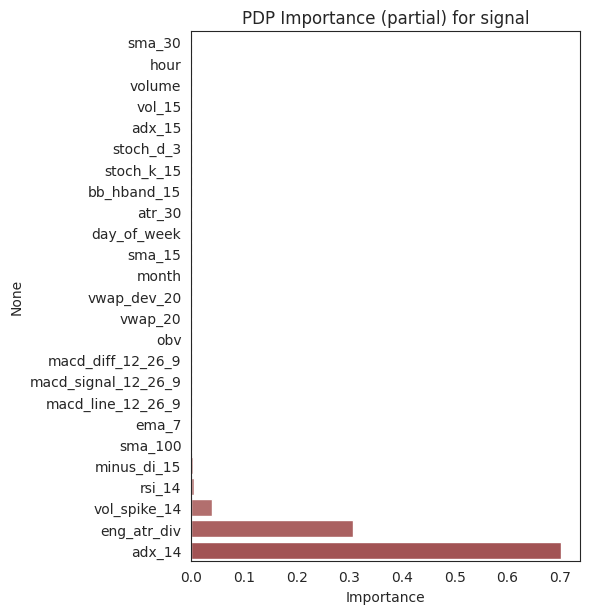

In [43]:
'''
# 7) PDP live (partial dependence)

Partial dependence plots isolate the marginal effect of one feature on the
prediction by averaging out all other features.  The range (max–min) of the
PDP curve quantifies how much that feature can move the model’s output.

How this function works:
  • Loop over each feature and compute its PDP with sklearn’s partial_dependence
    (handling different return formats for compatibility).  
  • Extract the averaged predictions vs. grid_values for that feature.  
  • Compute importance as the vertical range of the PDP curve.  
  • Stream the resulting importance scores using live_feature_importance.  
  • Finally, save the PDP‐based Series under "pdp" in your feature‐importance dict.
'''


pdp_importances = {}
pdp_raw = {}

for feat in features_cols:
    pdp_res = partial_dependence(
        estimator=rf,
        X=df_feat_filt[features_cols],
        features=[feat],
        grid_resolution=200,               # increase grid_resolution=50 → 100, 200, 500
        kind="average",
        percentiles=(0, 1)                # <<< MINIMAL FIX: span from min to max
    )

    # 1) Extract grid & values robustly
    if hasattr(pdp_res, "average") and hasattr(pdp_res, "grid_values"):
        # sklearn ≥1.2
        values = pdp_res.average[0]
        grid   = pdp_res.grid_values[0]
    elif isinstance(pdp_res, dict) and "values" in pdp_res:
        # older Bunch: 'values' key
        values = pdp_res["average"][0]
        grid   = pdp_res["values"][0]
    elif isinstance(pdp_res, tuple) and len(pdp_res) == 2:
        # tuple return: (avg, axes)
        vals, axes = pdp_res
        values = vals[0]
        grid   = axes[0]
    else:
        # fallback: use display to grab data
        from sklearn.inspection import PartialDependenceDisplay
        disp = PartialDependenceDisplay.from_estimator(
            estimator=rf,
            X=df_feat_filt[features_cols],
            features=[feat],
            grid_resolution=50,
            kind="average",
            plot=False
        )
        line   = disp.lines_[0][0]
        grid   = line.get_xdata()
        values = line.get_ydata()

    # 2) Compute importance = range of the average PDP curve
    imp = float(np.max(values) - np.min(values))
    pdp_importances[feat] = imp
    pdp_raw[feat] = (grid, values)

# Convert to Series
pdp_scores = pd.Series(pdp_importances, index=features_cols)

# Live‐plot helper expects compute_fn(feat) → float
def pdp_fn(feat):
    return pdp_scores[feat]

pdp_scores_live = live_feature_importance(
    df_feat_filt,
    features_cols,
    label_col,
    method="PDP",
    compute_fn=pdp_fn,
    threshold=0.0
)

# Store final PDP scores
update_feature_importances(features_importances, "pdp", pdp_scores)


In [44]:
# Finally inspect the combined table
fi_df = pd.DataFrame.from_dict(features_importances, orient="index")
fi_df

,corr,mi,lasso,rfe,perm_imp,perm_CV,shap,pdp
rsi_14,0.348318,0.084739,0.051411,0.004332,0.004332,-0.002541,0.001607,0.004683
macd_line_12_26_9,0.317043,0.061264,0.014839,0.000000,0.000000,-0.002751,0.000000,0.000000
macd_signal_12_26_9,-0.249199,0.044496,0.000000,0.000000,0.000000,-0.002751,0.000000,0.000000
macd_diff_12_26_9,0.133370,0.012665,0.005848,0.000000,0.000000,-0.002751,0.000000,0.000000
sma_100,0.329352,0.071471,0.020677,0.001278,0.001278,-0.002754,0.000863,0.001470
adx_14,0.317109,0.017693,0.024467,0.782454,0.782454,0.024532,0.083770,0.702380
obv,0.058372,0.002471,0.006046,0.000000,0.000000,-0.002751,0.000000,0.000000
vwap_20,0.271837,0.010839,0.000000,0.000000,0.000000,-0.002751,0.000000,0.000000
vol_spike_14,0.213598,0.032265,0.000000,0.046366,0.046366,-0.001775,0.012148,0.040050
vwap_dev_20,0.226072,0.010220,0.000000,0.000000,0.000000,-0.002751,0.000000,0.000000


In [45]:
def compute_global_importance(
    fi_df: pd.DataFrame,
    method_weights: dict[str, float] | None = None,
    plot: bool = False,
    top_n: int | None = None,
    figsize: tuple[float, float] = (10, 6),
    bar_kwargs: dict = None
) -> dict[str, float]:
    """
    Combine multiple feature‐importance measures into one global score,
    and optionally plot the results.

    Args:
      fi_df: DataFrame with index=features and columns=importance methods
      method_weights: dict of {method: weight}. Missing methods → weight 0. 
      plot: if True, draw a horizontal bar plot of global importance
      top_n: if set, only plot the top_n features
      figsize: figure size passed to plt.figure
      bar_kwargs: extra kwargs passed to plt.barh (e.g., color, alpha)

    Returns:
      A dict mapping feature names to their combined importance, sorted high→low.
    """
    # 0) fill missing
    fi_df = fi_df.fillna(0.0)

    # 1) Prepare weights
    methods = fi_df.columns.tolist()
    if method_weights is None:
        weights = {m: 1.0 for m in methods}
    else:
        weights = {m: method_weights.get(m, 0.0) for m in methods}

    # 2) Normalize each column to [0,1]
    norm_df = pd.DataFrame(index=fi_df.index)
    for m in methods:
        vals = fi_df[m].abs()
        max_val = vals.max()
        norm_df[m] = vals / max_val if max_val > 0 else vals

    # 3) Weighted sum
    weighted_sum = pd.Series(0.0, index=fi_df.index)
    for m, w in weights.items():
        weighted_sum += norm_df[m] * w

    # 4) Rescale to [0,1]
    total_w = sum(weights.values())
    if total_w > 0:
        weighted_sum /= total_w

    # 5) Sort descending
    global_importance = (
        weighted_sum
        .sort_values(ascending=False)
        .to_dict()
    )

    # 6) Plot if requested
    if plot:
        _plot_global_importance(global_importance,
                                top_n=top_n,
                                figsize=figsize,
                                bar_kwargs=bar_kwargs or {})

    return global_importance


def _plot_global_importance(
    global_imp: dict[str, float],
    top_n: int | None = None,
    figsize: tuple[float, float] = (10, 6),
    bar_kwargs: dict = None
):
    """
    Internal helper to draw a horizontal bar chart of feature importances.
    """
    # Convert to Series for easy slicing
    imp_series = pd.Series(global_imp)
    if top_n is not None:
        imp_series = imp_series.iloc[:top_n]

    # Create plot
    plt.figure(figsize=figsize)
    plt.barh(imp_series.index, imp_series.values, **(bar_kwargs or {}))
    plt.xlabel("Global Importance (0–1)")
    plt.title("Feature Global Importance")
    plt.gca().invert_yaxis()  # highest at top
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


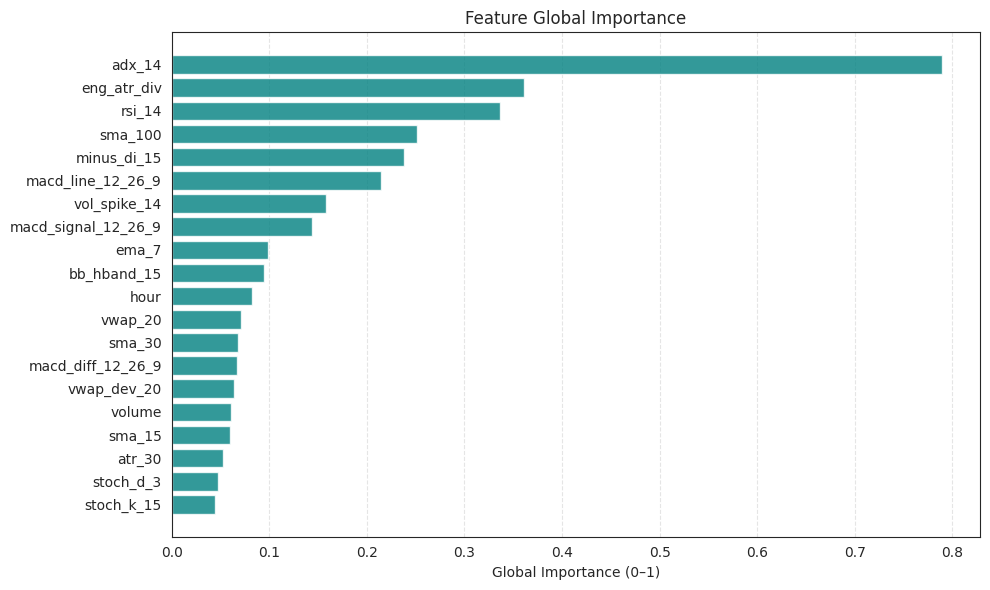

adx_14               → 0.789
eng_atr_div          → 0.361
rsi_14               → 0.337
sma_100              → 0.252
minus_di_15          → 0.238
macd_line_12_26_9    → 0.215
vol_spike_14         → 0.158
macd_signal_12_26_9  → 0.144
ema_7                → 0.099
bb_hband_15          → 0.095
hour                 → 0.083
vwap_20              → 0.071
sma_30               → 0.068
macd_diff_12_26_9    → 0.067
vwap_dev_20          → 0.064
volume               → 0.061
sma_15               → 0.060
atr_30               → 0.052
stoch_d_3            → 0.047
stoch_k_15           → 0.045


In [46]:
top_feat_numb = 20

my_weights = {
    'corr':    0.5,
    'mi':      2.0,
    'perm_CV': 1.0,
    'shap':    2.0,
    'lasso':   1.0,
    'rfe':     1.0,
    'perm_imp':1.5,
    'pdp':     1.5
}

# assuming compute_global_importance is already defined (with fillna inside)
global_imp = compute_global_importance(
    fi_df,
    method_weights=my_weights,
    plot=True,                    # draws bar chart
    top_n=top_feat_numb,          
    bar_kwargs={
        'color': 'teal',
        'alpha': 0.8
    }
)

features_cols_sel = []
# display top features and scores
for feat, score in list(global_imp.items())[:top_feat_numb]:
    print(f"{feat:20s} → {score:.3f}")
    features_cols_sel.append(feat)



In [47]:
def correlation_screen(fi_df: pd.DataFrame,
                       threshold: float = 0.9,
                       plot: bool = True) -> list[tuple[str,str]]:
    """
    Correlation measures how two variables move together.

    It ranges from –1 (perfect opposite) through 0 (no linear link) to +1 (perfect together).
    
    Returns list of feature pairs whose absolute correlation exceeds threshold.
    Optionally plots a heatmap.
    """
    # 1. compute correlation matrix
    corr = fi_df.corr().abs()

    # 2. mask self‐correlations
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    # 3. optionally plot
    if plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, mask=~mask, annot=False, cmap='vlag', center=0,
                    linewidths=0.5, cbar_kws={'shrink':0.75})
        plt.title("Feature Correlation Heatmap")
        plt.show()

    # 4. find high‐corr pairs
    high_corr = []
    for i, j in zip(*np.where((corr > threshold) & mask)):
        feat_i = corr.index[i]
        feat_j = corr.columns[j]
        high_corr.append((feat_i, feat_j))

    return high_corr


In [48]:
def compute_vif(
    fi_df: pd.DataFrame,
    thresh: float = 10.0,
    verbose: bool = True
) -> pd.DataFrame:
    """
    VIF (Variance Inflation Factor) shows how much a single predictor’s variance is inflated by its linear relationships with all the other predictors.

    Computes VIF for each numeric, non‐constant feature in fi_df.
    Drops constant columns, fills NaNs→0, adds an intercept, then computes VIF.
    Flags features with VIF > thresh.
    
    Returns a DataFrame with columns: feature, VIF, flag.
    """
    # 1) Fill missing
    df = fi_df.copy().fillna(0.0)

    # 2) Keep only float/int cols
    df_num = df.select_dtypes(include=[np.number])

    # 3) Drop constant columns (zero variance)
    variances = df_num.var(axis=0)
    non_const_cols = variances[variances > 0.0].index.tolist()
    df_num = df_num[non_const_cols]

    # 4) If fewer than 2 features, we can’t compute VIF
    if df_num.shape[1] < 2:
        if verbose:
            print("Less than 2 non‐constant numeric features → no VIF to compute.")
        return pd.DataFrame({
            'feature': df_num.columns,
            'VIF': [0.0]*df_num.shape[1],
            'flag': [False]*df_num.shape[1]
        })

    # 5) Add intercept (constant) column
    X = add_constant(df_num, has_constant='add')

    # 6) Compute VIF for each feature (skip constant at idx=0)
    vif_records = []
    for i, feature in enumerate(df_num.columns, start=1):
        try:
            v = variance_inflation_factor(X.values, i)
        except Exception as e:
            if verbose:
                print(f"  → Could not compute VIF for {feature}: {e}")
            v = np.nan
        vif_records.append({
            'feature': feature,
            'VIF': v,
            'flag': bool(v and v > thresh)
        })

    vif_df = pd.DataFrame(vif_records).sort_values('VIF', ascending=False)
    return vif_df


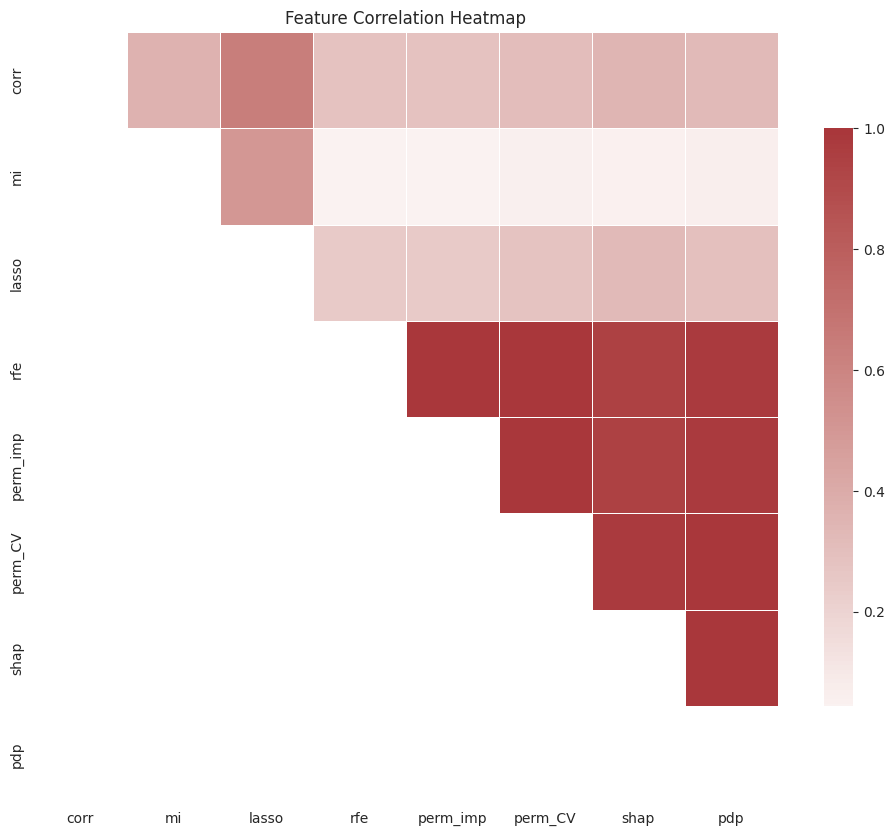

High‐corr feature pairs: [('rfe', 'perm_imp'), ('rfe', 'perm_CV'), ('rfe', 'shap'), ('rfe', 'pdp'), ('perm_imp', 'perm_CV'), ('perm_imp', 'shap'), ('perm_imp', 'pdp'), ('perm_CV', 'shap'), ('perm_CV', 'pdp'), ('shap', 'pdp')]


In [49]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Run correlation / VIF on X_df
# ──────────────────────────────────────────────────────────────────────────────

high_corr_pairs = correlation_screen(fi_df, threshold=0.9, plot=True)
print("High‐corr feature pairs:", high_corr_pairs)

In [50]:
vif_df = compute_vif(fi_df, thresh=10.0)
print(vif_df)

    feature           VIF   flag
3       rfe           inf   True
4  perm_imp           inf   True
7       pdp  2.043750e+05   True
5   perm_CV  1.997397e+05   True
6      shap  1.397463e+04   True
2     lasso  6.457846e+00  False
0      corr  1.920915e+00  False
1        mi  1.680102e+00  False


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [51]:
features_cols_sel

['adx_14',
 'eng_atr_div',
 'rsi_14',
 'sma_100',
 'minus_di_15',
 'macd_line_12_26_9',
 'vol_spike_14',
 'macd_signal_12_26_9',
 'ema_7',
 'bb_hband_15',
 'hour',
 'vwap_20',
 'sma_30',
 'macd_diff_12_26_9',
 'vwap_dev_20',
 'volume',
 'sma_15',
 'atr_30',
 'stoch_d_3',
 'stoch_k_15']